<a href="https://colab.research.google.com/github/hkiiskin/ML-Project1/blob/main/S%26P_500_Stock_Data_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torchmetrics
!pip install pytorch_lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 9.7 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score

from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Libraries

import torch
import torch.nn as nn
from torch import Tensor
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchmetrics.functional import accuracy as ACC

from torchsummary import summary

import pytorch_lightning as pl

## Load & preprocess the Dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 619029 entries, 0 to 619039
Data columns (total 16 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        619029 non-null  datetime64[ns]
 1   open        619029 non-null  float64       
 2   high        619029 non-null  float64       
 3   low         619029 non-null  float64       
 4   close       619029 non-null  float64       
 5   volume      619029 non-null  int64         
 6   Name        619029 non-null  int64         
 7   open_close  619029 non-null  float64       
 8   by_year     619029 non-null  int64         
 9   by_month    619029 non-null  int64         
 10  by_date     619029 non-null  int64         
 11  by_day      619029 non-null  int64         
 12  week        619029 non-null  int64         
 13  month       619029 non-null  int64         
 14  year        619029 non-null  int64         
 15  target      619029 non-null  int64         
dtypes:

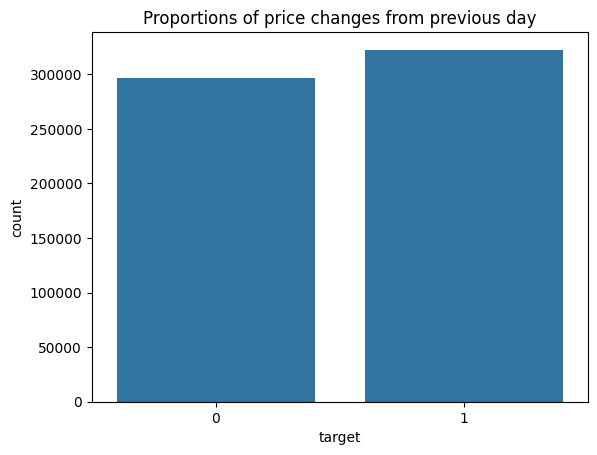

,date,open,high,low,close,volume,Name,open_close,by_year,by_month,by_date,by_day,week,month,year,target
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,1,-0.32,2013,2,8,4,0,1,1,0
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,1,-0.43,2013,2,11,0,0,1,1,0
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,1,-0.18,2013,2,12,1,0,1,1,1
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,1,0.36,2013,2,13,2,0,1,1,0
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,1,-0.95,2013,2,14,3,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,504,0.98,2018,2,1,3,0,0,0,0
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,504,-0.75,2018,2,2,4,0,0,0,0
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,504,-2.81,2018,2,5,0,0,0,0,0
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,504,0.53,2018,2,6,1,0,0,0,1


In [12]:
class Load_Preprocess():
    def __init__(self, path='all_stocks_5yr.csv'):
        self.df = pd.read_csv(path)
        self.Target_proportions()

    def Target_proportions(self):
        # Change format
        # self.df = self.df.replace(' ', np.nan)
        self.df = self.df.dropna()

        self.df['date'] = pd.to_datetime(self.df['date'])
        self.df['Name'] = self.df['Name'].astype('string')
        label_encoder = preprocessing.LabelEncoder()
        # Encode labels in column 'call2'.
        self.df['Name']= label_encoder.fit_transform(self.df['Name'])

        # Define more features
        self.df['open_close'] = (self.df['close'] - self.df['open'])
        self.df['by_year'] = self.df['date'].dt.year
        self.df['by_month'] = self.df['date'].dt.month
        self.df['by_date'] = self.df['date'].dt.day
        self.df['by_day'] = self.df['date'].dt.dayofweek
        self.df['week'] = (self.df['close'].shift(-5) > self.df['close']).astype(int)
        self.df['month'] = (self.df['close'].shift(-21) > self.df['close']).astype(int)
        self.df['year'] = (self.df['close'].shift(-260) > self.df['close']).astype(int)

        # Define target based on +/- from previous day
        self.df['target'] = (self.df['close'].shift(-1) > self.df['close']).astype(int)

        # self.df = self.df.drop(self.df[self.df.date < '2014-02-08'].index, inplace=True)
        # self.df = self.df.drop_duplicates(subset=['Name', 'open_close'], keep='first')
        print(self.df.info())
        sns.countplot(x=self.df['target']).set_title('Proportions of price changes from previous day')
        plt.show()

    def Preprocessing(self):
        # X = self.df.iloc[:, [6,7,9,10,11,12,13]].to_numpy()
        X = self.df.iloc[:, 1:15].to_numpy()
        y = self.df.iloc[:, 15].to_numpy()

        # Scale the the features
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

        # X_under, y_under = self.Rebalance_Target_Data(X_train, y_train)

        return X_train, X_val, X_test, y_train, y_val, y_test

LP = Load_Preprocess()
X_train, X_val, X_test, y_train, y_val, y_test = LP.Preprocessing()
LP.df

In [13]:
X_train.shape, y_train.shape, X_val.shape, X_test.shape, y_val.shape, y_test.shape

((495223, 14), (495223,), (61903, 14), (61903, 14), (61903,), (61903,))

# Neural Networks

In [14]:
class Stock_Dataset(Dataset):
    def __init__(self, Features, Labels):
        self.features = Features
        self.labels = Labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x, y = self.features[idx], self.labels[idx]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

train_data = Stock_Dataset(X_train, y_train)
val_data = Stock_Dataset(X_val, y_val)
test_data = Stock_Dataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=256, shuffle=True)#, drop_last=True
val_loader = DataLoader(val_data, batch_size=256, shuffle=False)
test_loader = DataLoader(test_data, batch_size=256, shuffle=False)

In [15]:
train_data.__getitem__(0)#, val_data.__getitem__(0), test_data.__getitem__(0),

(tensor([-0.1515, -0.1441, -0.1476, -0.1433, -0.1098,  0.4804,  0.5133, -0.0866,
          0.7128, -0.6549,  0.7012, -1.0974, -1.1729,  0.7551]),
 tensor(0))

In [17]:
train_data.__getitem__(0)[0].shape

torch.Size([14])

In [19]:
class Stock_Classier(pl.LightningModule):
    def __init__(self):
        super(Stock_Classier, self).__init__()
        self.hidden1 = nn.Linear(14, 256)
        self.hidden2 = nn.Linear(256, 128)
        # self.bn = nn.BatchNorm1d(128)
        # self.hidden3 = nn.Linear(128, 128)
        # self.attention1 = nn.Parameter(128, 128)
        self.dropout = nn.Dropout(p=0.2)
        self.hidden4 = nn.Linear(128, 32)
        self.output = nn.Linear(32, 2)

        # self.activation = nn.ReLU(inplace=True)
        self.activation = nn.LeakyReLU(0.25)
        self.CE = nn.CrossEntropyLoss()
        # self.CE = nn.BCEWithLogitsLoss()

    def forward(self, x):
        out = self.activation(self.hidden1(x))
        out = self.activation(self.hidden2(out))
        # out = self.bn(out)
        # out = self.activation(self.hidden3(out))
        out = self.dropout(out)
        out = self.activation(self.hidden4(out))

        out = self.output(out)
        return out

    def training_step(self, batch, batch_idx):
        images, labels = batch
        preds = self(images)

        loss = self.CE(preds, labels)
        acc = ACC(preds, labels, task="multiclass", num_classes=2)

        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        preds = self(images)

        loss = self.CE(preds, labels)
        acc = ACC(preds, labels, task="multiclass", num_classes=2)

        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def test_step(self, test_batch, batch_idx):
        images, labels = test_batch
        preds = self.forward(images)

        loss = self.CE(preds, labels)
        acc = ACC(preds, labels, task="multiclass", num_classes=2)

        self.log('test_loss', loss)
        self.log('test_acc', acc, prog_bar=True)

    def predict_step(self, test_batch, batch_idx):
        images, labels = test_batch
        preds = self.forward(images)

        # Apply softmax to get probability distribution over classes
        probabilities = F.softmax(preds, dim=1)

        # Get class predictions by finding the class with the highest probability
        _, predicted_classes = torch.max(probabilities, dim=1)

        return predicted_classes.tolist()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.01)


In [20]:
torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Model = Stock_Classier().to(device)
print(Model)
device

Stock_Classier(
  (hidden1): Linear(in_features=14, out_features=256, bias=True)
  (hidden2): Linear(in_features=256, out_features=128, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (hidden4): Linear(in_features=128, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=2, bias=True)
  (activation): LeakyReLU(negative_slope=0.25)
  (CE): CrossEntropyLoss()
)


'cuda'

In [21]:
trainer = pl.Trainer(max_epochs=10)#, gradient_clip_val=1.0
trainer.fit(Model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params
------------------------------------------------
0 | hidden1    | Linear           | 3.8 K 
1 | hidden2    | Linear           | 32.9 K
2 | dropout    | Dropout          | 0     
3 | hidden4    | Linear           | 4.1 K 
4 | output     | Linear           | 66    
5 | activation | LeakyReLU        | 0     
6 | CE         | CrossEntropyLoss | 0     
------------------------------------------------
40.9 K    Trainable params
0         Non-trainable params
40.9 K    Total params
0.164     Total estima

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir=lightning_logs/

In [22]:
predictions = trainer.predict(Model, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [41]:
result = trainer.test(Model, test_loader)
result

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.640728235244751     │
│         test_loss         │    0.6492233276367188     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6492233276367188, 'test_acc': 0.640728235244751}]

Confusion Matrix
[[16956 12712]
 [ 9528 22707]]


<Axes: >

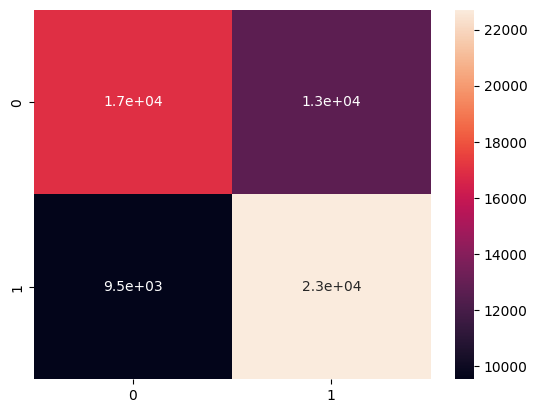

In [40]:
# Collect predictions to one array
y_pred = []
for i in predictions:
  y_pred = np.concatenate((y_pred, i))

# Plot Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)
sns.heatmap(cm, annot=True)